In [1]:
import sys
sys.path.insert(1, '/users/facsupport/asharma/RNN-shifts/preprocessing')

from data_prep import initial_preprocess

### Generate dataset

RAW_DATA_PATH = '/export/storage_adgandhi/PBJ_data_prep/pbj_full.csv'
PREPROCESSED_DIR = '/users/facsupport/asharma/Data/test'

df, info = initial_preprocess(
    RAW_DATA_PATH, PREPROCESSED_DIR,
    nrows=100000,  
    fill_missing_shifts=True,
    normalize=False,
    day_of_week=True,
    prev_shifts=30,
    fac_data=True
)
df
print(df.columns)

Loading preprocessed data from '/users/facsupport/asharma/Data/testpbj_nrows_100000_zeros_prev_shifts_30_dow_fac.csv'...
Loading related info from '/users/facsupport/asharma/Data/testpbj_nrows_100000_zeros_prev_shifts_30_dow_fac.info.csv'...
Index(['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9',
       't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18',
       't_19', 't_20', 't_21', 't_22', 't_23', 't_24', 't_25', 't_26', 't_27',
       't_28', 't_29', 't_30', 'hours', 'employee_id', 'date', 'job_title',
       'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit',
       'avg_dailycensus', 'sd_dailycensus'],
      dtype='object')


In [2]:
import pandas as pd
import lightgbm as lgb

# Keep "interesting" jobs (TODO - use strings instead)
df = df[df['job_title'].isin([33,34,35,11,12,3,5,16,17])]
df['date'] = pd.to_datetime(df['date']).astype(int)
# Convert necessary values to boolean
df.multifac = df.multifac.map(dict(Yes=1, No=0))
df.profit = df.profit.map(dict(Yes=1, No=0))
#Drop employee id and date columns
df = df.drop(columns=['employee_id','date'])

# %%
# ========================================
#          SPLIT & PREP DATAFRAME
# ========================================

inputs = df.drop(['t_0', 'hours'], axis=1)
labels = df.filter(['t_0'])

# Weights to split data set
TRAINING_WEIGHT = 0.7
VALIDATION_WEIGHT = 0.2
TEST_WEIGHT = 0.1

n = len(df)
weights_sum = TRAINING_WEIGHT + VALIDATION_WEIGHT + TEST_WEIGHT
split1 = int(TRAINING_WEIGHT / weights_sum * n)
split2 = int((TRAINING_WEIGHT + VALIDATION_WEIGHT) / weights_sum * n)

train_inputs, train_labels = inputs[:split1], labels[:split1]
val_inputs, val_labels = inputs[split1:split2], labels[split1:split2]
test_inputs, test_labels = inputs[split2:], labels[split2:]

print(train_inputs)
print(train_labels)


        t_1   t_2   t_3   t_4   t_5   t_6   t_7   t_8   t_9  t_10  ...  t_30  \
0      7.50  0.00  0.00  8.25  8.00  7.75  7.50  0.00  0.00  8.00  ...  7.50   
1      7.75  7.50  0.00  0.00  8.25  8.00  7.75  7.50  0.00  0.00  ...  7.75   
2      8.00  7.75  7.50  0.00  0.00  8.25  8.00  7.75  7.50  0.00  ...  7.75   
3      8.00  8.00  7.75  7.50  0.00  0.00  8.25  8.00  7.75  7.50  ...  0.00   
4      0.00  8.00  8.00  7.75  7.50  0.00  0.00  8.25  8.00  7.75  ...  0.00   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
46722  7.25  7.50  7.75  8.25  8.50  0.00  0.00  8.25  7.75  7.75  ...  8.00   
46723  0.00  7.25  7.50  7.75  8.25  8.50  0.00  0.00  8.25  7.75  ...  8.00   
46724  0.00  0.00  7.25  7.50  7.75  8.25  8.50  0.00  0.00  8.25  ...  0.00   
46725  0.00  0.00  7.75  7.75  7.50  7.50  0.00  0.00  8.00  7.75  ...  7.75   
46726  7.50  0.00  0.00  7.75  7.75  7.50  7.50  0.00  0.00  8.00  ...  7.50   

       job_title  prov_id  pay_type  da

In [3]:
# %%
# ========================================
#          DATAFRAME TO LGB DS
# ========================================

cats = ['job_title', 'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit']

train_data = lgb.Dataset(train_inputs, label=train_labels, categorical_feature=cats)
val_data = lgb.Dataset(val_inputs, label=val_labels, categorical_feature=cats)
test_data = lgb.Dataset(test_inputs, label=test_labels, categorical_feature=cats)
print(train_data)

In [4]:
# %%
# ========================================
#            TRAIN WITH LGB
# ========================================
param = {
   'num_leaves': 150,
   'learning_rate': 0.05,
   'metric': 'mse',
   'boosting': 'gbdt',
}
evals_result = {}
bst = lgb.train(param, train_data, valid_sets=[val_data], evals_result=evals_result, early_stopping_rounds=5)

/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7735
[LightGBM] [Info] Number of data points in the train set: 46727, number of used features: 39
[LightGBM] [Info] Start training from score 4.764275


/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's l2: 18.163
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 17.4472
[3]	valid_0's l2: 16.797
[4]	valid_0's l2: 16.2007
[5]	valid_0's l2: 15.6652
[6]	valid_0's l2: 15.1892
[7]	valid_0's l2: 14.7489
[8]	valid_0's l2: 14.3504
[9]	valid_0's l2: 13.9733
[10]	valid_0's l2: 13.6376
[11]	valid_0's l2: 13.3262
[12]	valid_0's l2: 13.042
[13]	valid_0's l2: 12.7794
[14]	valid_0's l2: 12.5401
[15]	valid_0's l2: 12.3266
[16]	valid_0's l2: 12.1167
[17]	valid_0's l2: 11.9316
[18]	valid_0's l2: 11.761
[19]	valid_0's l2: 11.6117
[20]	valid_0's l2: 11.4665
[21]	valid_0's l2: 11.3354
[22]	valid_0's l2: 11.2158
[23]	valid_0's l2: 11.0962
[24]	valid_0's l2: 11.0024
[25]	valid_0's l2: 10.912
[26]	valid_0's l2: 10.8182
[27]	valid_0's l2: 10.7299
[28]	valid_0's l2: 10.6559
[29]	valid_0's l2: 10.587
[30]	valid_0's l2: 10.5162
[31]	valid_0's l2: 10.4509
[32]	valid_0's l2: 10.3941
[33]	valid_0's l2: 10.3539
[34]	valid_0's l2: 10.3026
[35]	valid_0's l2: 10.2639
[36]	valid

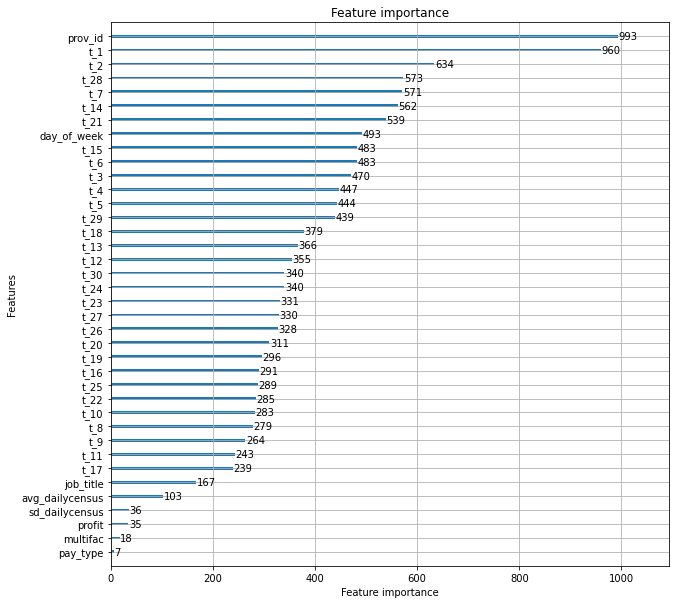

In [5]:
# %%
# =========================================
#          LGB Influence Scores
# =========================================

axes = lgb.plot_importance(bst,figsize=(10,10))

In [9]:
pd.unique(df['prov_id'])

array([ 5, 13, 12,  8,  3,  9, 15, 11,  7,  6, 10,  1, 14,  4,  2])

In [10]:
pd.unique(df['avg_dailycensus'])

array([ 56.15,  96.99, 133.11,  86.62,  37.  ,  94.99,  90.4 ,  59.32,
        68.62, 103.55,  86.47,  34.1 ,  42.39,  55.72,  55.91])

In [23]:
predictions = bst.predict(test_inputs)
errorSum=0

for i in range(len(test_labels)):
    print(f"Prediction: {predictions[i]} True Value: {test_labels.iloc[i]['t_0']}")
    errorSum += abs(predictions[i]-test_labels.iloc[i]['t_0'])
    
print(f"Mean absolute error {errorSum/len(test_labels)}")

Prediction: 3.000686928576919 True Value: 0.0
Prediction: 5.477925508968892 True Value: 0.0
Prediction: 6.504532985215188 True Value: 7.93
Prediction: 7.654341269933285 True Value: 7.73
Prediction: 3.1180072997838058 True Value: 8.67
Prediction: 5.426711904677128 True Value: 0.0
Prediction: 2.962158039859219 True Value: 7.68
Prediction: 6.919265086259381 True Value: 7.72
Prediction: 8.056744867613224 True Value: 7.82
Prediction: 5.341222018404882 True Value: 0.0
Prediction: 5.794147541732161 True Value: 0.0
Prediction: 5.978352898456215 True Value: 0.0
Prediction: 3.418556206243056 True Value: 0.0
Prediction: 1.4838201814299312 True Value: 0.0
Prediction: 1.4139505049031411 True Value: 0.0
Prediction: 3.328241459860904 True Value: 0.0
Prediction: 2.962848614114865 True Value: 7.77
Prediction: 7.46493706742803 True Value: 8.38
Prediction: 6.447384565594652 True Value: 0.17
Prediction: 4.902813883991966 True Value: 0.0
Prediction: 4.716845406816197 True Value: 7.9
Prediction: 7.892359690

Prediction: 2.0917791804802985 True Value: 0.0
Prediction: 2.6446616778262584 True Value: 0.0
Prediction: 6.639409662057411 True Value: 9.77
Prediction: 8.174184935430278 True Value: 12.34
Prediction: 8.43325002450677 True Value: 6.88
Prediction: 5.63129663488735 True Value: 4.17
Prediction: 4.8725757300078225 True Value: 7.88
Prediction: 3.228490739518769 True Value: 0.0
Prediction: 3.8558049821130385 True Value: 0.0
Prediction: 6.544442779524802 True Value: 0.0
Prediction: 3.931980609029164 True Value: 0.0
Prediction: 3.0058617415398614 True Value: 8.2
Prediction: 7.166695930758795 True Value: 8.57
Prediction: 6.750291997342732 True Value: 8.33
Prediction: 1.7573458929616497 True Value: 0.0
Prediction: 2.2913882136771595 True Value: 0.0
Prediction: 6.457890887931922 True Value: 8.85
Prediction: 2.024531757127847 True Value: 0.0
Prediction: 2.3324829963488503 True Value: 0.0
Prediction: 0.5584815748897017 True Value: 0.0
Prediction: 0.19842308538059153 True Value: 0.0
Prediction: 0.51

Prediction: 4.861195514676415 True Value: 1.0
Prediction: 6.806926590331797 True Value: 6.5
Prediction: 5.10944348522796 True Value: 1.0
Prediction: 6.480183577457595 True Value: 6.5
Prediction: 3.84740089037271 True Value: 1.0
Prediction: 6.541472210227655 True Value: 7.5
Prediction: 6.373316733831709 True Value: 7.5
Prediction: 6.712586492476127 True Value: 7.5
Prediction: 4.613388301517778 True Value: 6.5
Prediction: 2.2946455487654305 True Value: 0.0
Prediction: 3.470726746809488 True Value: 1.0
Prediction: 6.975145593098097 True Value: 7.5
Prediction: 6.920195682919875 True Value: 7.5
Prediction: 4.101095470071941 True Value: 6.75
Prediction: 2.1364215756477933 True Value: 1.0
Prediction: 6.320645902879868 True Value: 7.5
Prediction: 6.810336484828359 True Value: 7.5
Prediction: 6.5466392525808805 True Value: 6.5
Prediction: 1.7297061586747462 True Value: 1.0
Prediction: 7.33376797111174 True Value: 7.5
Prediction: 5.91696864696176 True Value: 7.5
Prediction: 7.132233202660429 Tru

Prediction: 1.3728518540300811 True Value: 0.0
Prediction: 4.391532708260543 True Value: 7.0
Prediction: 0.7011241853464055 True Value: 0.0
Prediction: 4.3898332252592285 True Value: 6.75
Prediction: 0.6936693914092631 True Value: 0.0
Prediction: 0.62322345508579 True Value: 6.75
Prediction: 4.514366392702019 True Value: 0.0
Prediction: 2.524258597948886 True Value: 0.0
Prediction: 3.100632996796136 True Value: 7.0
Prediction: 0.7860631338414228 True Value: 0.0
Prediction: 3.731480956614091 True Value: 6.25
Prediction: 2.0924810336999444 True Value: 0.0
Prediction: 1.9088062227704419 True Value: 0.0
Prediction: 1.926330305144375 True Value: 0.0
Prediction: 1.0237767337353036 True Value: 1.0
Prediction: 6.0805957478957415 True Value: 6.75
Prediction: 0.510179474777859 True Value: 0.0
Prediction: 4.33268843131383 True Value: 0.25
Prediction: 2.1508761822641076 True Value: 0.0
Prediction: 2.9622363262948475 True Value: 6.5
Prediction: 6.854316181928215 True Value: 7.5
Prediction: 6.209155

Prediction: 5.507483473167785 True Value: 5.75
Prediction: 4.171573113281178 True Value: 5.75
Prediction: 2.9594141896732316 True Value: 5.75
Prediction: 6.209980368082919 True Value: 0.0
Prediction: 0.8385350237549011 True Value: 0.0
Prediction: 0.5032616864161121 True Value: 0.0
Prediction: 3.7457735787271953 True Value: 7.5
Prediction: 6.358006821070407 True Value: 5.25
Prediction: 5.172858450822506 True Value: 6.75
Prediction: 6.089803750904986 True Value: 6.25
Prediction: 0.7879171009338782 True Value: 0.0
Prediction: 0.21640525694065393 True Value: 0.0
Prediction: 4.820721040534454 True Value: 7.5
Prediction: 7.096322044470557 True Value: 0.0
Prediction: 4.016914403590583 True Value: 0.0
Prediction: 2.3042185833616187 True Value: 0.0
Prediction: 1.2247555875981677 True Value: 0.0
Prediction: 1.151340573353458 True Value: 0.0
Prediction: 4.80823130022745 True Value: 7.25
Prediction: 5.5886624274284955 True Value: 5.75
Prediction: 6.870944901939729 True Value: 0.0
Prediction: 4.878

Prediction: 5.4646487681953 True Value: 0.0
Prediction: 3.720307501279879 True Value: 0.0
Prediction: 3.3879912496917197 True Value: 5.5
Prediction: 5.803427315482864 True Value: 0.0
Prediction: 1.9443834566899387 True Value: 0.0
Prediction: 0.7651978623745962 True Value: 0.0
Prediction: 1.274680181783996 True Value: 0.0
Prediction: 4.255288441978307 True Value: 7.75
Prediction: 6.824548473744599 True Value: 0.0
Prediction: 2.9508289112105466 True Value: 0.0
Prediction: 4.411375461762008 True Value: 7.75
Prediction: 6.040054982634847 True Value: 7.5
Prediction: 6.06096497047634 True Value: 0.0
Prediction: 1.8662161167220421 True Value: 0.0
Prediction: 3.989143284707279 True Value: 0.0
Prediction: 1.7314651827729346 True Value: 0.0
Prediction: 3.619975425885496 True Value: 7.7
Prediction: 3.50763953486054 True Value: 7.75
Prediction: 2.6696994521702577 True Value: 7.75
Prediction: 3.3237801221758767 True Value: 8.0
Prediction: 4.770919361492213 True Value: 8.25
Prediction: 4.13957253290

Prediction: 6.696711191825697 True Value: 7.5
Prediction: 5.223182323698875 True Value: 7.5
Prediction: 4.482781412238419 True Value: 7.75
Prediction: 4.342138509372915 True Value: 0.0
Prediction: 4.346205629975835 True Value: 0.0
Prediction: 4.83845310093642 True Value: 7.5
Prediction: 2.562965027795404 True Value: 0.0
Prediction: 1.1364618818053724 True Value: 0.0
Prediction: 5.8281144515024685 True Value: 7.5
Prediction: 7.038863831653963 True Value: 7.5
Prediction: 6.718956710331739 True Value: 0.0
Prediction: 1.9451109065703944 True Value: 0.0
Prediction: 0.6315193122237235 True Value: 7.75
Prediction: 6.771174013670499 True Value: 7.5
Prediction: 6.547672183195788 True Value: 7.5
Prediction: 5.037186882571623 True Value: 0.0
Prediction: 2.5787203118253395 True Value: 0.0
Prediction: 4.305664572340284 True Value: 7.75
Prediction: 6.747687181074207 True Value: 0.0
Prediction: 2.3482642553710393 True Value: 11.75
Prediction: 5.414928945786421 True Value: 0.0
Prediction: 4.6972489324

In [21]:
type(test_labels.iloc[0]['t_0'])

numpy.float64